# Starting cluster

## Prerequisites
First, you need to install MPI, on windows use MS-MPI:
https://msdn.microsoft.com/en-us/library/bb524831(v=vs.85).aspx


## With a profile (not working)
In theory, you should be able to create a profile using
```
ipython profile create --parallel --profile=myprofile
```
and then set
```
c.IPClusterEngines.engine_launcher_class = 'MPIEngineSetLauncher'
```
in ```<IPYTHON-DIR>/profile_myprofile/ipcluster_config.py```. This should then enable you to start a cluster using
```
ipcluster start --profile=myprofile
```
or alternatively through the Clusters tab in Jupyter


## Without a profile (not working)
An alternative is to run
```
ipcluster start --engines=MPI
```


## Manual start (working)
This, however, does *not* work for me on Windows. What does work is the following:

Start a controller using
```
ipcontroller --ip='*'
```
and then start several engines using mpiexec:
```
mpiexec -n 4 ipengine --mpi
```

In [1]:
from GPUSimulators import IPythonMagic

In [2]:
%setup_logging --out mpi.log my_logger

Console logger using level INFO
File logger using level DEBUG to mpi.log
Python version 3.7.2 (default, Mar 13 2019, 14:18:46) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [3]:
%setup_mpi mpi_context --num_engines 3

Starting IPController
Starting IPEngines
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Waiting for cluster...
Done


In [4]:
%%px

%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from mpi4py import MPI

from GPUSimulators import IPythonMagic
from GPUSimulators.MPISimulator import MPISimulator

In [5]:
%%px
%setup_logging --out "'mpi_' + str(MPI.COMM_WORLD.rank) + '.log'"

CompositeError: one or more exceptions from call to method: execute
[0:execute]: UsageError: the following arguments are required: name
[1:execute]: UsageError: the following arguments are required: name
[2:execute]: UsageError: the following arguments are required: name

In [6]:
%%px
%cuda_context_handler -na my_context

In [7]:
%%px

def gatherData(data):
    ny, nx = data.shape
    
    retval = []
    if (sim.rank == 0):        
        mpi_requests = []
        retval += [data]
        for k in range(1, sim.comm.size):
            buffer = np.empty((ny, nx), dtype=np.float32)
            retval += [buffer]
            mpi_requests += [sim.comm.Irecv(buffer, source=k, tag=k)]
            
        for mpi_request in mpi_requests:
            mpi_request.wait()
    else:
        mpi_request = sim.comm.Isend(data, dest=0, tag=sim.rank)
        mpi_request.wait()
        
    return retval

def getExtent(sim, rank):
    i, j = sim.getCoordinate(rank)
    width = sim.nx * sim.dx
    height = sim.ny * sim.dy
    x0 = i * width
    y0 = j * height 
    x1 = x0+width
    y1 = y0+height
    return [x0, x1, y0, y1]

def plotExtent(extent, *args, **kwargs):
    x0, x1, y0, y1 = extent
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], *args, **kwargs)

[stderr:0] MPISimulator [128x256]: 0% [#############################=] 100%. Total: 8s, elapsed: 8s, remaining: 1s
[stderr:1] 
MPISimulator [128x256]: 0% [############################==] 100%. Total: 5s, elapsed: 5s, remaining: 1s
MPISimulator [128x256]: 0% [#############################=] 100%. Total: 15s, elapsed: 11s, remaining: 4s
[stderr:2] MPISimulator [128x256]: 0% [#############################=] 100%. Total: 8s, elapsed: 8s, remaining: 1s


[output:0]

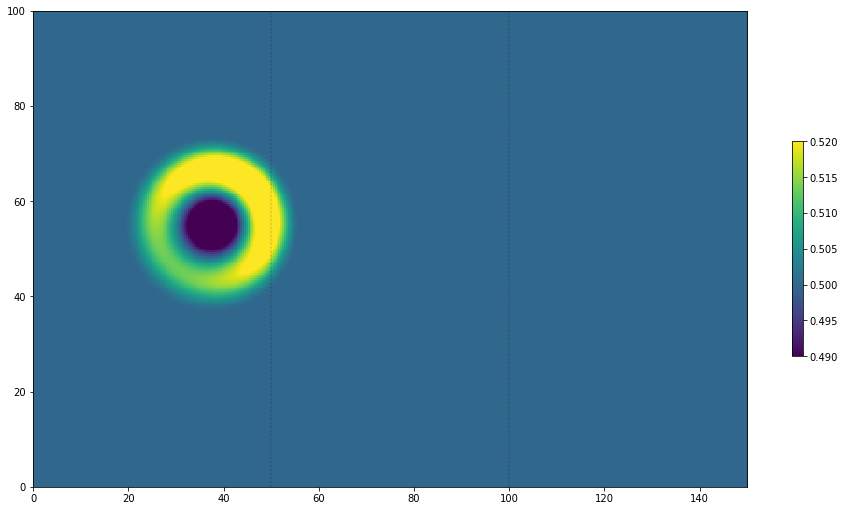

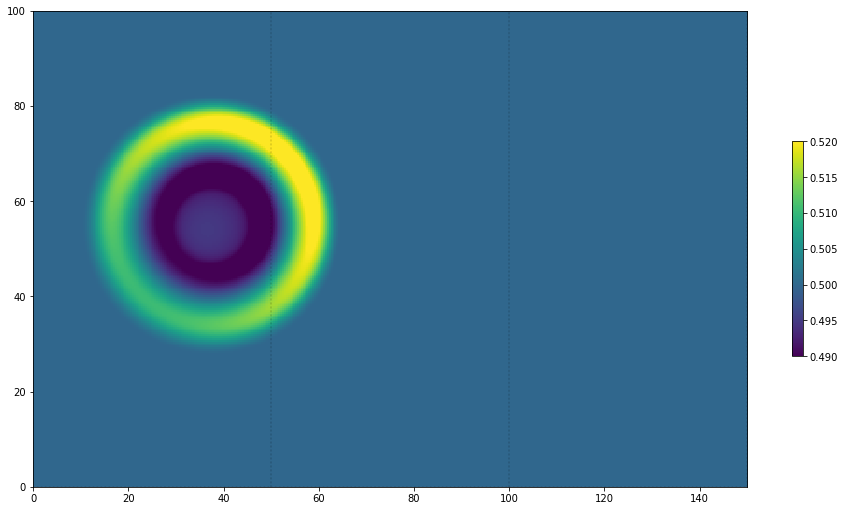

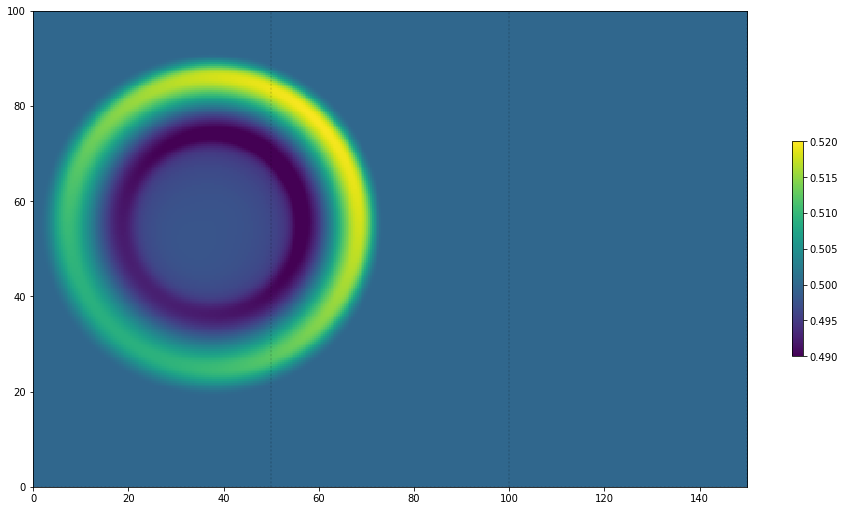

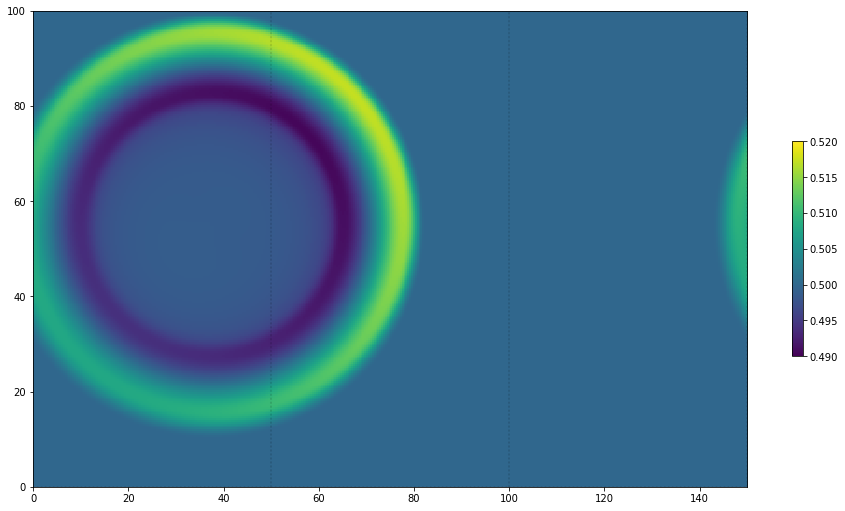

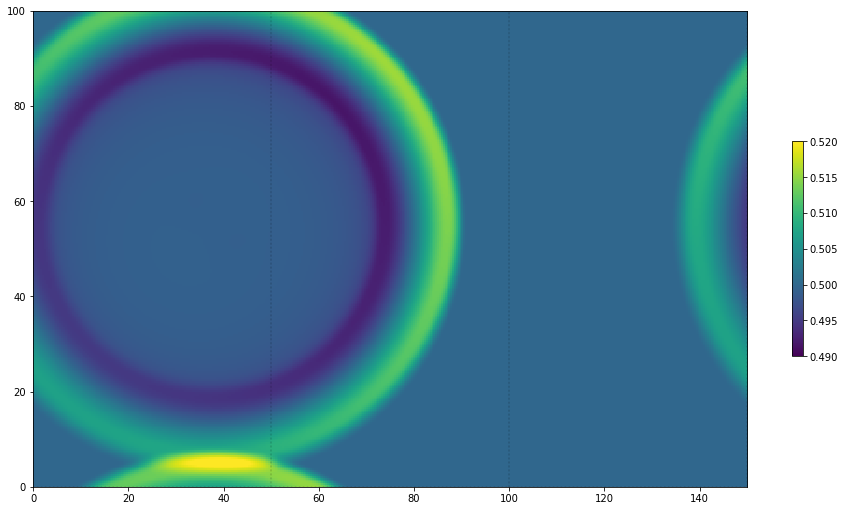

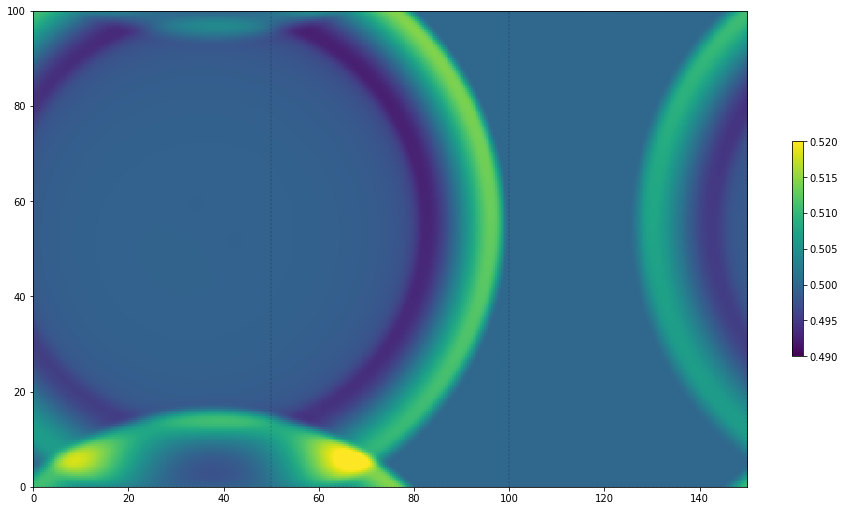

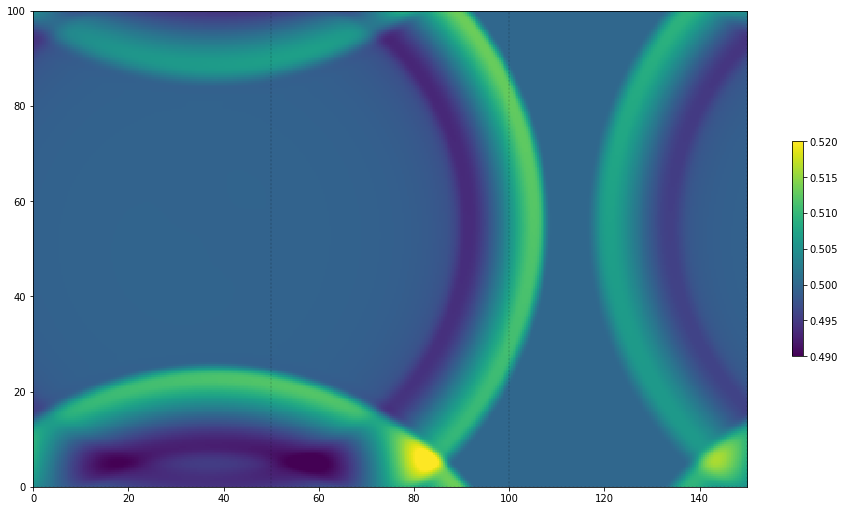

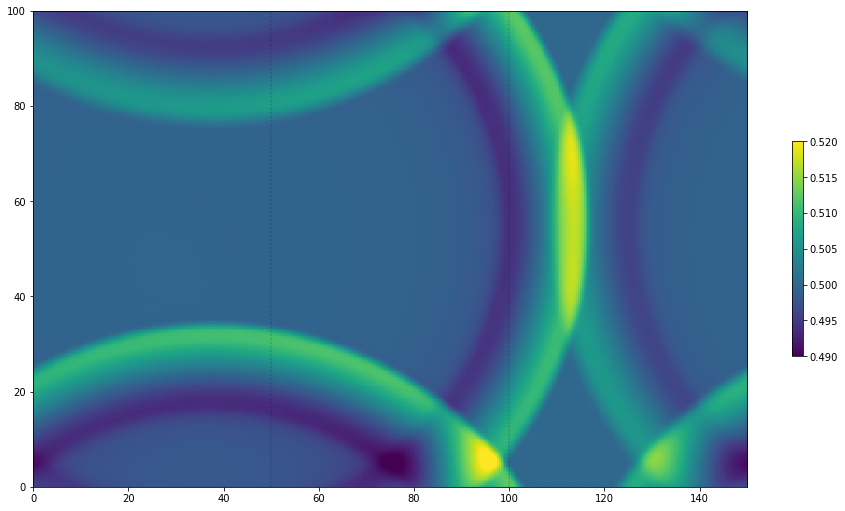

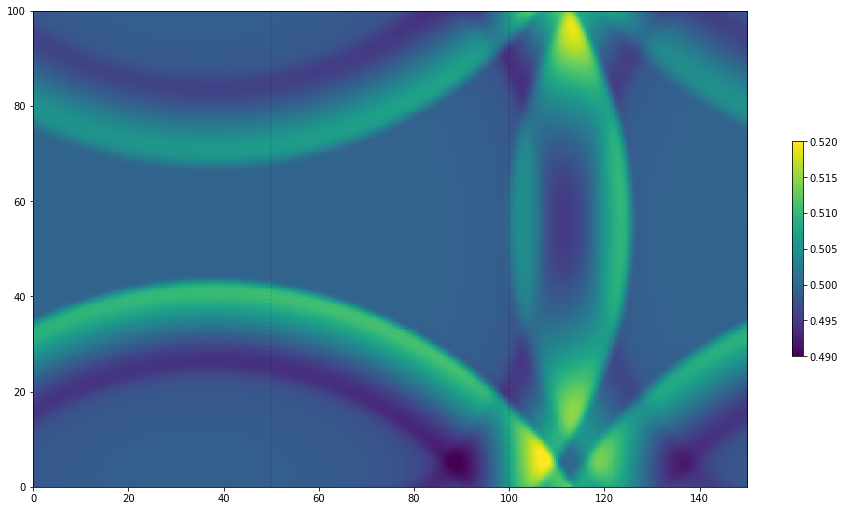

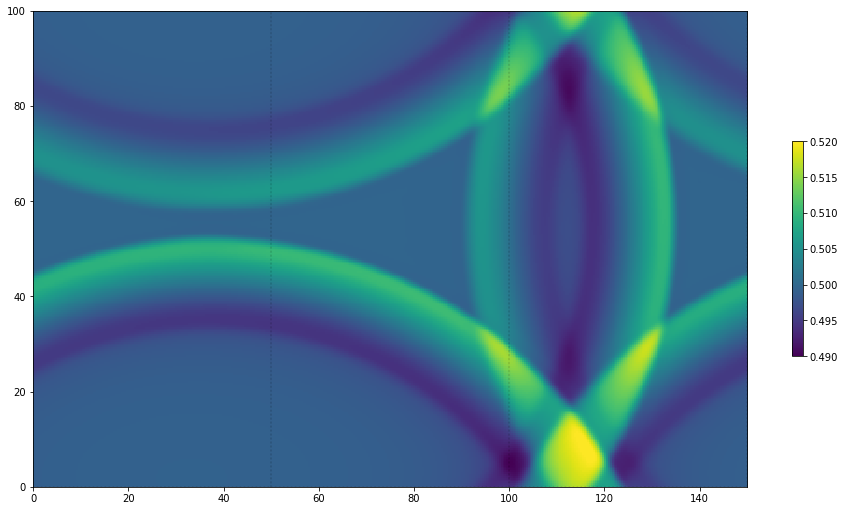

In [8]:
%%px

from GPUSimulators.helpers import InitialConditions
from GPUSimulators.Simulator import BoundaryCondition

nx = 128
ny = 256
g = 9.81
dt = 0.05
width = 50
height = 100


if (MPI.COMM_WORLD.rank == 0):
    h0, hu0, hv0, dx, dy = InitialConditions.bump(nx, ny, width, height, g, x_center=0.75, y_center=0.55)
else:
    h0, hu0, hv0, dx, dy = InitialConditions.bump(nx, ny, width, height, g, h_ref=0.5, h_amp=0.0, u_amp=0.0, v_amp=0.0)
    
bc = BoundaryCondition({
    'north': BoundaryCondition.Type.Dirichlet,
    'south': BoundaryCondition.Type.Dirichlet,
    'east': BoundaryCondition.Type.Dirichlet,
    'west': BoundaryCondition.Type.Dirichlet
})

arguments = {
    'context': my_context,
    'h0': h0, 'hu0': hu0, 'hv0': hv0,
    'nx': nx, 'ny': ny,
    'dx': dx, 'dy': dy, 
    'g': g,
    'boundary_conditions': bc
} 

from GPUSimulators import HLL2

local_sim = HLL2.HLL2(**arguments)
sim = MPISimulator(local_sim, MPI.COMM_WORLD)

n_steps = 10
t_end = 40#n_steps*dt #2*dt

for i in range(n_steps):
    sim.simulate(t_end/n_steps)
    
    h, hu, hv = sim.download()
    data = gatherData(h)
    
    if (sim.rank == 0):
        plt.figure(figsize=(16, 12))
        for k in range(sim.comm.size):
            extent = getExtent(sim, k)
            plt.imshow(data[k], extent=extent, origin='lower', vmin=0.49, vmax=0.52)
            plotExtent(extent, 'k:', alpha=0.1)
        plt.colorbar(shrink=0.33)

[stderr:0] 
MPISimulator [128x256]: 0% [######################========] 100%. Total: 6s, elapsed: 5s, remaining: 1s
MPISimulator [128x256]: 0% [####################==========] 100%. Total: 7s, elapsed: 5s, remaining: 2s
MPISimulator [128x256]: 0% [##################============] 100%. Total: 8s, elapsed: 5s, remaining: 3s
MPISimulator [128x256]: 0% [###############===============] 100%. Total: 9s, elapsed: 5s, remaining: 4s
MPISimulator [128x256]: 0% [################==============] 100%. Total: 9s, elapsed: 5s, remaining: 4s
MPISimulator [128x256]: 0% [#################=============] 100%. Total: 8s, elapsed: 5s, remaining: 3s
MPISimulator [128x256]: 0% [###############===============] 100%. Total: 10s, elapsed: 5s, remaining: 5s
MPISimulator [128x256]: 0% [###############===============] 100%. Total: 9s, elapsed: 5s, remaining: 4s
MPISimulator [128x256]: 0% [###############===============] 100%. Total: 10s, elapsed: 5s, remaining: 5s
MPISimulator [128x256]: 0% [######################

[output:0]

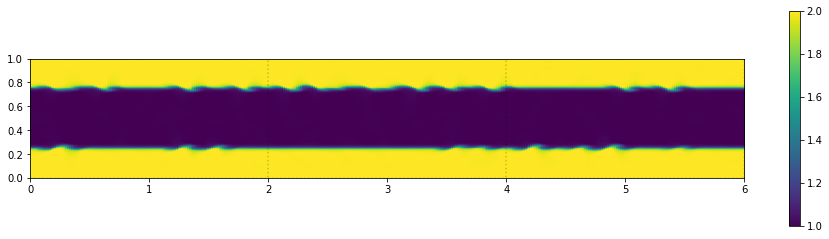

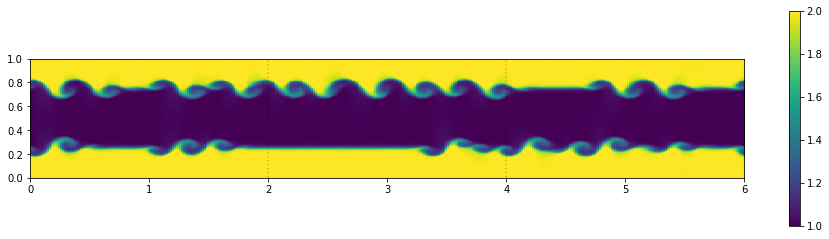

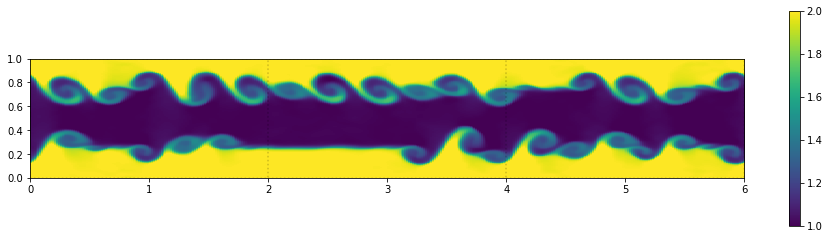

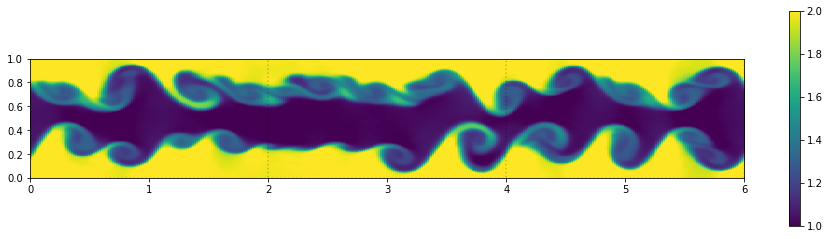

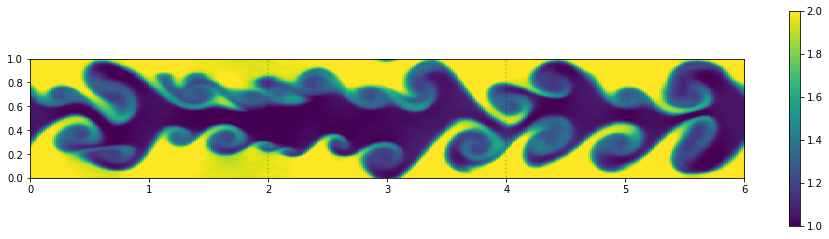

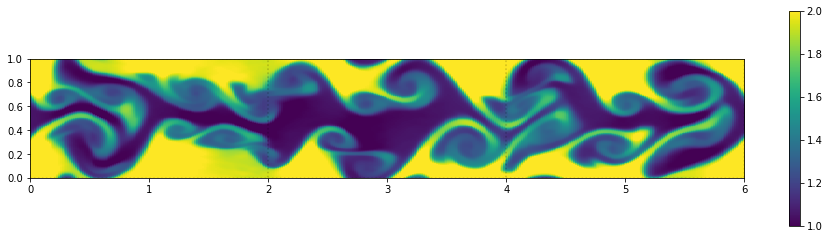

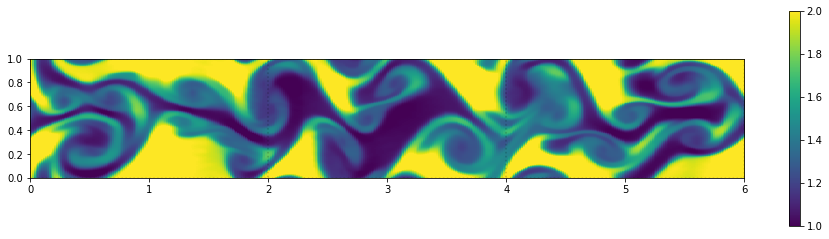

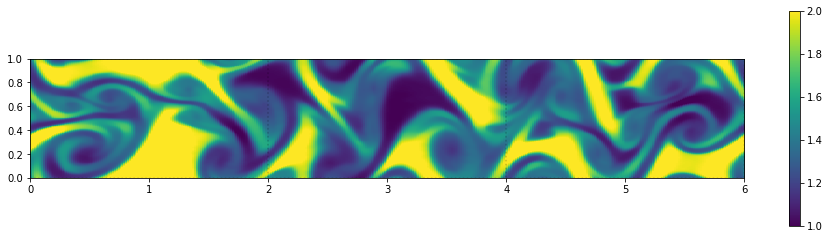

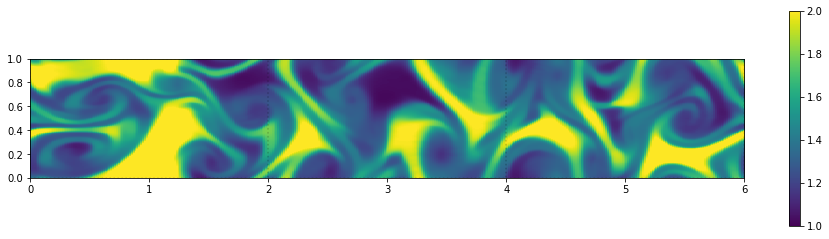

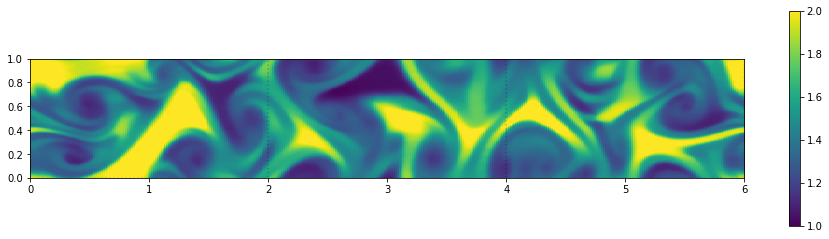

In [9]:
%%px

from GPUSimulators.helpers import InitialConditions
from GPUSimulators.Simulator import BoundaryCondition

my_context.autotuner = None

nx = 128
ny = 256
gamma = 1.4

arguments = InitialConditions.genKelvinHelmholtz(nx, ny, gamma)

"""
if (MPI.COMM_WORLD.rank == 0):
    arguments['rho'].fill(3.81250)
    arguments['rho_u'].fill(3.81250*2.57669)
    arguments['rho_v'].fill(0.0)
    arguments['E'].fill(0.5*3.81250*(3.81250*2.57669*3.81250*2.57669) + 10.0/(gamma-1.0))
    arguments = InitialConditions.genShockBubble(nx, ny, gamma)
else:
    arguments['rho'].fill(1.0)
    arguments['rho_u'].fill(0.0)
    arguments['rho_v'].fill(0.0)
    arguments['E'].fill(1.0/(gamma-1.0))
"""
    
bc = BoundaryCondition({
    'north': BoundaryCondition.Type.Dirichlet,
    'south': BoundaryCondition.Type.Dirichlet,
    'east': BoundaryCondition.Type.Dirichlet,
    'west': BoundaryCondition.Type.Dirichlet
})

arguments['context'] = my_context
arguments['theta'] = 1.2
arguments['boundary_conditions'] = bc


from GPUSimulators import EE2D_KP07_dimsplit

local_sim = EE2D_KP07_dimsplit.EE2D_KP07_dimsplit(**arguments)
sim = MPISimulator(local_sim, MPI.COMM_WORLD)

n_steps = 10
t_end = 5.0#n_steps*dt #2*dt

for i in range(n_steps):
    sim.simulate(t_end/n_steps)
    
    rho, rho_u, rho_v, E = sim.download()
    data = gatherData(rho)
    if (sim.rank == 0):
        plt.figure(figsize=(16, 12))
        for k in range(sim.comm.size):
            extent = getExtent(sim, k)
            plt.imshow(data[k], extent=extent, origin='lower', vmin=1.0, vmax=2.0)
            plotExtent(extent, 'k:', alpha=0.1)
        plt.colorbar(shrink=0.33)